# Large Data Work Flow using Pandas

## Objective

Handle large data sets using Pandas; reduce a dataframe’s memory footprint by almost 90%, by selecting the appropriate data types for columns.

## Data Set

The data come from 130 years of major league baseball games, originally sourced from [Retrosheet](working with data from 130 years of major league baseball games, originally sourced from Retrosheet.). Originally the data was in 127 separate CSV files, however the team at Dataquest have used csvkit to merge the files, and have added column names into the first row and made it available [here](https://data.world/dataquest/mlb-game-logs).

Importing the data and taking a look at the first five rows.

In [1]:
import pandas as pd

gl = pd.read_csv('C:/Users/i7/csv/game_logs.csv')
gl.head()

F:\ANACONDA\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (12,13,14,15,19,20,81,83,85,87,93,94,95,96,97,98,99,100,105,106,108,109,111,112,114,115,117,118,120,121,123,124,126,127,129,130,132,133,135,136,138,139,141,142,144,145,147,148,150,151,153,154,156,157,160) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,...,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,18710504,0,Thu,CL1,na,1,FW1,na,1,0,...,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,18710505,0,Fri,BS1,na,1,WS3,na,1,20,...,Asa Brainard,1.0,burrh101,Henry Burroughs,9.0,berth101,Henry Berthrong,8.0,HTBF,Y
2,18710506,0,Sat,CL1,na,2,RC1,na,1,12,...,Pony Sager,6.0,birdg101,George Bird,7.0,stirg101,Gat Stires,9.0,NaN,Y
3,18710508,0,Mon,CL1,na,3,CH1,na,1,12,...,Ed Duffy,6.0,pinke101,Ed Pinkham,5.0,zettg101,George Zettlein,1.0,NaN,Y
4,18710509,0,Tue,BS1,na,2,TRO,na,1,9,...,Steve Bellan,5.0,pikel101,Lip Pike,3.0,cravb101,Bill Craver,6.0,HTBF,Y


Summarized some of the important columns below:

| Column       | Description                                |
|--------------|--------------------------------------------|
| date         | Date of the game.                          |
| v_name       | Visiting team name.                        |
| v_league     | Visiting team league.                      |
| h_name       | Home team name.                            |
| h_league     | Home team league.                          |
| v_score      | Visiting team score.                       |
| h_score      | Home team score.                           |
| v_line_score | Visiting team line score, eg 010000(10)00. |
| h_line_score | Home team line score, eg 010000(10)0X.     |
| park_id      | ID of the park where the game was held.    |
| attendance   | Game attendance.                           |

## Information about data types and memory usage.

In [2]:
gl.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171907 entries, 0 to 171906
Columns: 161 entries, date to acquisition_info
dtypes: float64(77), int64(6), object(78)
memory usage: 860.5 MB


Looking at the average memory usage for data type.

In [3]:
for dtype in ['float','int','object']:
    selected_dtype = gl.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 1.29 MB
Average memory usage for int columns: 0.00 MB
Average memory usage for object columns: 9.51 MB


Notice that most of memory is used by 78 object columns.

## Optimizing Numeric Columns with Subtypes

In [5]:
gl_float = gl.select_dtypes(include=['float'])
converted_float = gl_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(gl_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([gl_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

100.99 MB
50.49 MB


,before,after
float32,NaN,77.0
float64,77.0,NaN


See that all float columns were converted from float64 to float32, giving a 50% reduction in memory usage.

Create a copy of original dataframe, assign these optimized numeric columns in place of the originals, and see what overall memory usage is now.

In [6]:
optimized_gl = gl.copy()

optimized_gl[converted_float.columns] = converted_float

print(mem_usage(gl))
print(mem_usage(optimized_gl))

860.50 MB
810.01 MB


It appears that dramatically reduced the memory usage of the numeric columns, overall only reduced the memory usage of the dataframe by 7%. Most of the gains are going to come from optimizing the object types.

## Optimizing object types using Categoricals

In [8]:
gl_obj = gl.select_dtypes(include=['object']).copy()
gl_obj.describe()

,day_of_week,v_name,v_league,h_name,h_league,day_night,completion,forefeit,protest,park_id,...,h_player_6_id,h_player_6_name,h_player_7_id,h_player_7_name,h_player_8_id,h_player_8_name,h_player_9_id,h_player_9_name,additional_info,acquisition_info
count,171907,171907,171907,171907,171907,140150,116,145,180,171907,...,140838,140838,140838,140838,140838,140838,140838,140838,1456,140841
unique,7,148,7,148,7,2,116,3,5,245,...,4774,4720,5253,5197,4760,4710,5193,5142,332,1
top,Sat,CHN,NL,CHN,NL,D,"20140901,,2,2,35",H,V,STL07,...,grimc101,Charlie Grimm,grimc101,Charlie Grimm,lopea102,Al Lopez,spahw101,Warren Spahn,HTBF,Y
freq,28891,8870,88866,9024,88867,82724,1,69,90,7022,...,427,427,491,491,676,676,339,339,1112,140841


In [9]:
dow = gl_obj.day_of_week
print(dow.head())

dow_cat = dow.astype('category')
print(dow_cat.head())

0    Thu
1    Fri
2    Sat
3    Mon
4    Tue
Name: day_of_week, dtype: object
0    Thu
1    Fri
2    Sat
3    Mon
4    Tue
Name: day_of_week, dtype: category
Categories (7, object): [Fri, Mon, Sat, Sun, Thu, Tue, Wed]


In [10]:
print(mem_usage(dow))
print(mem_usage(dow_cat))

9.84 MB
0.16 MB


Its gone from 9.8MB of memory usage to 0.16MB of memory usage, or a 98% reduction!

## Caveats

Write a loop to iterate over each object column, check if the number of unique values is less than 50%, and if so, convert it to the category type.

In [11]:
converted_obj = pd.DataFrame()

for col in gl_obj.columns:
    num_unique_values = len(gl_obj[col].unique())
    num_total_values = len(gl_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = gl_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = gl_obj[col]

In [12]:
print(mem_usage(gl_obj))
print(mem_usage(converted_obj))

compare_obj = pd.concat([gl_obj.dtypes,converted_obj.dtypes],axis=1)
compare_obj.columns = ['before','after']
compare_obj.apply(pd.Series.value_counts)

751.64 MB
42.49 MB


Exception ignored in: 'pandas.lib.array_equivalent_object'
TypeError: data type not understood


,before,after
object,78.0,NaN
category,NaN,78.0


Memory usage for the object columns has gone from 752MB to 52MB, or a reduction of 93%. Combine this with the rest of the dataframe and see where it sit in relation to the 861MB memory usage we started with.

In [13]:
optimized_gl[converted_obj.columns] = converted_obj

mem_usage(optimized_gl)

'100.85 MB'

## Optimizing datetime types

In [14]:
date = optimized_gl.date
print(mem_usage(date))
date.head()

1.31 MB


0    18710504
1    18710505
2    18710506
3    18710508
4    18710509
Name: date, dtype: int64

In [15]:
optimized_gl['date'] = pd.to_datetime(date,format='%Y%m%d')

print(mem_usage(optimized_gl))
optimized_gl.date.head()

100.85 MB


0   1871-05-04
1   1871-05-05
2   1871-05-06
3   1871-05-08
4   1871-05-09
Name: date, dtype: datetime64[ns]

## Selecting Types While Reading the Data In

In [16]:
dtypes = optimized_gl.drop('date',axis=1).dtypes

dtypes_col = dtypes.index
dtypes_type = [i.name for i in dtypes.values]

column_types = dict(zip(dtypes_col, dtypes_type))

# rather than print all 161 items,
# sample 10 key/value pairs from the dict
# and print it nicely using prettyprint

preview = first2pairs = {key:value for key,value in list(column_types.items())[:10]}

import pprint
pp = pp = pprint.PrettyPrinter(indent=4)
pp.pprint(preview)

{   'day_of_week': 'category',
    'h_game_number': 'int64',
    'h_league': 'category',
    'h_name': 'category',
    'h_score': 'int64',
    'number_of_game': 'int64',
    'v_game_number': 'int64',
    'v_league': 'category',
    'v_name': 'category',
    'v_score': 'int64'}


In [18]:
read_and_optimized = pd.read_csv('C:/Users/i7/csv/game_logs.csv',dtype=column_types,parse_dates=['date'],infer_datetime_format=True)

print(mem_usage(read_and_optimized))
read_and_optimized.head()

100.84 MB


,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,...,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,1871-05-04,0,Thu,CL1,na,1,FW1,na,1,0,...,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,1871-05-05,0,Fri,BS1,na,1,WS3,na,1,20,...,Asa Brainard,1.0,burrh101,Henry Burroughs,9.0,berth101,Henry Berthrong,8.0,HTBF,Y
2,1871-05-06,0,Sat,CL1,na,2,RC1,na,1,12,...,Pony Sager,6.0,birdg101,George Bird,7.0,stirg101,Gat Stires,9.0,NaN,Y
3,1871-05-08,0,Mon,CL1,na,3,CH1,na,1,12,...,Ed Duffy,6.0,pinke101,Ed Pinkham,5.0,zettg101,George Zettlein,1.0,NaN,Y
4,1871-05-09,0,Tue,BS1,na,2,TRO,na,1,9,...,Steve Bellan,5.0,pikel101,Lip Pike,3.0,cravb101,Bill Craver,6.0,HTBF,Y


#### Summary :
By optimizing the columns, reduce the memory usage in pandas from 861.6 MB to 104.28 MB - an impressive 88% reduction!

## Analyzing baseball games

Look at how game length has varied over the years.

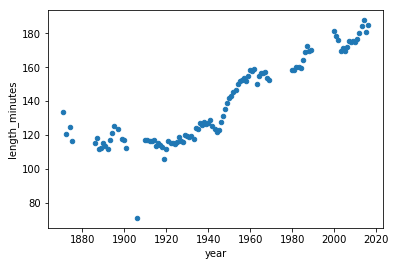

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

game_lengths = optimized_gl.pivot_table(index='year', values='length_minutes')
game_lengths.reset_index().plot.scatter('year','length_minutes')
plt.show()

Looks like baseball games have continued to get longer from the 1940s onwards